In [144]:
%load_ext autoreload
%autoreload 2

from utils import get_eval_stats, analyze_protein_gen_helper, analyze_protein_gen_helper_violin
from collect_experiments import collect_ddg_experiments

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


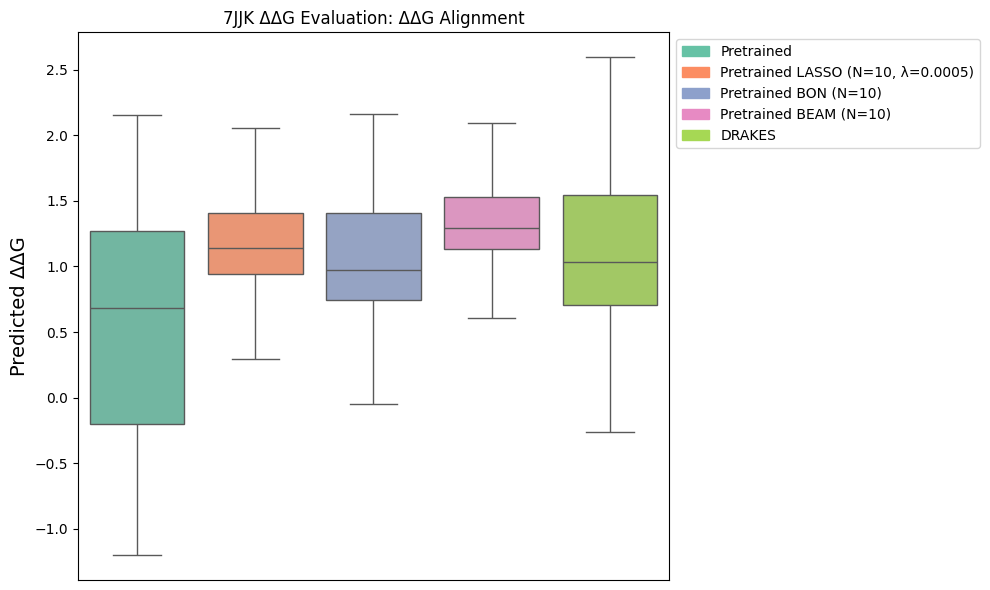

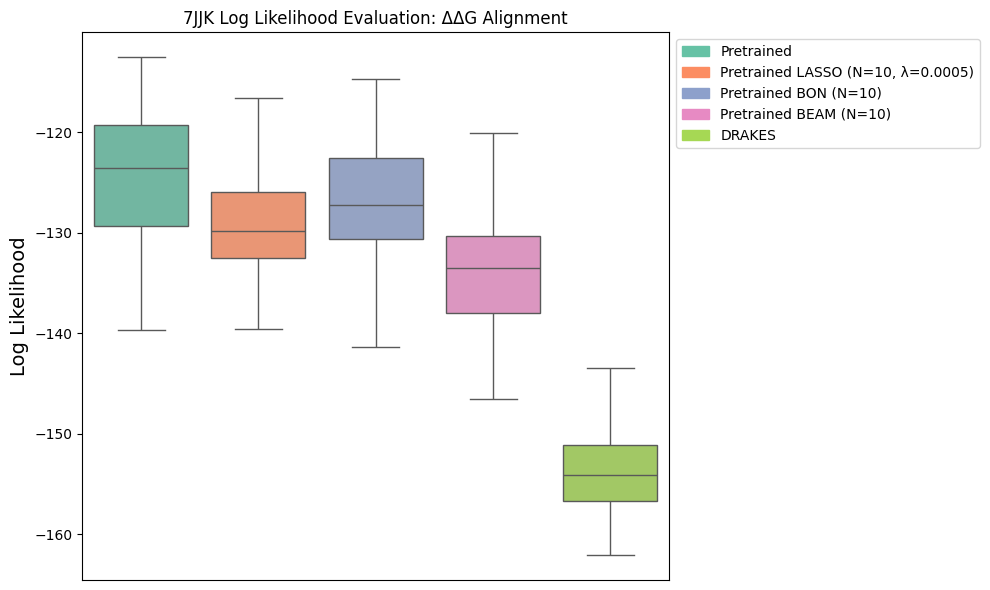

In [151]:
import seaborn as sn

experiments = collect_ddg_experiments()
data = [exp.get_df() for exp in experiments]
labels = [exp.name for exp in experiments]
colors = sn.color_palette("Set2", len(experiments))
target_protein = '7JJK'
protein_output = target_protein + " " if target_protein != "" else ""
analyze_protein_gen_helper_violin(target_protein, data, labels, colors, 'ddg_eval', y_label='Predicted ΔΔG', legend_pos='right', title=f'{protein_output}ΔΔG Evaluation: ΔΔG Alignment')
analyze_protein_gen_helper_violin(target_protein, data, labels, colors, 'loglikelihood', y_label='Log Likelihood', legend_pos='right', title=f'{protein_output}Log Likelihood Evaluation: ΔΔG Alignment')